In [2]:
from __future__ import annotations
from itertools import repeat

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from sklearn.metrics import (accuracy_score, confusion_matrix,
                            precision_score, recall_score, f1_score, 
                            precision_recall_curve,
                            roc_curve, roc_auc_score)
import torch
import torch.nn as nn
import torchvision as tv
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

from models import *

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE = 'cpu'

## MATPLOTLIB FIGURES STYLING
AXES_BACKGROUND = 'ivory'
FIG_BACKGROUND = 'whitesmoke'

# Datasets

## MNIST - digits

In [4]:
BATCH_SIZE = 512

mnist = np.load('mnist.npz')

dataloader = torch.utils.data.DataLoader(
    [*zip(mnist['x_train'][:, None, :, :] / 255, mnist['y_train'])], 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    drop_last=False,
    )

dataloader_val = torch.utils.data.DataLoader(
    [*zip(mnist['x_test'][:, None, :, :] / 255, mnist['y_test'])], 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    drop_last=False,
    )

CLASS_TO_LABEL_DICT = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9',
}

LABEL_TO_CLASS_DICT = {CLASS_TO_LABEL_DICT[key]: key for key in CLASS_TO_LABEL_DICT.keys()}

assert len(CLASS_TO_LABEL_DICT) == len(LABEL_TO_CLASS_DICT)


## CIFAR - 10

In [3]:
BATCH_SIZE = 32


transforms = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.ConvertImageDtype(dtype=torch.float),
    tv.transforms.Normalize(0, 1),                       
    tv.transforms.RandomHorizontalFlip(0.5),             # augmentation
    tv.transforms.ColorJitter(0.1, 0.1, 0.1, 0.1, ),     # augmentation
])

transforms_val = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.ConvertImageDtype(dtype=torch.float),
    tv.transforms.Normalize(0, 1),
])

dataset = tv.datasets.CIFAR10(r'D:\Datasets\CIFAR10', 
train=True, 
download=True, 
transform=transforms)

dataset_val = tv.datasets.CIFAR10(r'D:\Datasets\CIFAR10', 
train=False, 
download=True, 
transform=transforms_val)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    drop_last=False,
    )

dataloader_val = torch.utils.data.DataLoader(
    dataset_val, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False,
    )

CLASS_TO_LABEL_DICT = {
    0: 'airplane', 
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

LABEL_TO_CLASS_DICT = {CLASS_TO_LABEL_DICT[key]: key for key in CLASS_TO_LABEL_DICT.keys()}

assert len(CLASS_TO_LABEL_DICT) == len(LABEL_TO_CLASS_DICT)

Files already downloaded and verified
Files already downloaded and verified


# Tensorboard

In [35]:
tb = SummaryWriter('runs/mnet-1')

In [34]:
tb.close()

# Model

In [4]:
## MODEL

# model = LeNet_BN_DO(input_channels=3, output_classes=10, do=0.03).to(DEVICE)
model = MNet(in_channels=3, out_channels=10, base_width=30, do=0.03, stochastic_do=0.05, expansion=5).to(DEVICE)

In [11]:
## MODEL SUMMARY

print(summary(model, (1, 3, 32, 32),
            depth=3,
            row_settings=("depth", "var_names"),
            col_names=("input_size", "kernel_size", "output_size", "num_params"),
            device=DEVICE))
            

Layer (type (var_name):depth-idx)                            Input Shape               Kernel Shape              Output Shape              Param #
MNet                                                         --                        --                        --                        --
├─Sequential (prepare): 1-1                                  [1, 3, 32, 32]            --                        [1, 30, 28, 28]           --
│    └─Conv2d (0): 2-1                                       [1, 3, 32, 32]            [3, 30, 5, 5]             [1, 30, 28, 28]           2,250
├─Sequential (main_blocks): 1-2                              [1, 30, 28, 28]           --                        [1, 30, 28, 28]           --
│    └─IBB (0): 2-2                                          [1, 30, 28, 28]           --                        [1, 30, 28, 28]           --
│    │    └─Sequential (block): 3-1                          [1, 30, 28, 28]           --                        [1, 30, 28, 28]           2

In [5]:
## OPTIMIZER
LR = 0.003

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [25]:
## CHANGE LR
for pg in optimizer.param_groups:
    pg['lr'] = 0.0003

In [24]:
## GET CURRENT LR
for pg in optimizer.param_groups:
    print(pg['lr'])

0.001


# Training

In [7]:
loss_val = 0
step = 0

In [ ]:
SUBNAME = 'CIFAR10_MNet-1'

EPOCHS = 100
VALIDATION_UPDATE_INTERVAL = 1
VAL_FRACTION = 1  # fraction of validation dataset to use for validation along training process
SAVE_INTERVAL = 1  # save model weights and optimizer state every SAVE_INTERVAL epoch


val_steps = len(dataloader_val) * VAL_FRACTION

pbar = tqdm(range(EPOCHS), ncols=100)
for epoch in pbar:

    # VALIDATION UPDATE
    if not epoch % VALIDATION_UPDATE_INTERVAL:
        model.eval()
        loss_val_list = []
        for n, (x_val, target_val) in enumerate(dataloader_val):
            if n >= val_steps:
                break
            with torch.no_grad():
                res_val = model(x_val.float().to(DEVICE))
                loss_val_list.append(nn.CrossEntropyLoss()(res_val, target_val.to(torch.long).to(DEVICE)).item())
        loss_val = sum(loss_val_list) / val_steps
        tb.add_scalars(f'{model._get_name()} training', {f'{SUBNAME}/loss_val': loss_val}, global_step=step)

    # SAVE
    if SAVE_INTERVAL and epoch != 0 and not epoch % SAVE_INTERVAL:
        torch.save({'model': model.state_dict(), 'optimizer': optimizer.state_dict()}, f'checkpoints/{model._get_name()}-{SUBNAME}-step{step}.pth')

    # TRAINING
    model.train()
    for x, label in dataloader:             # for normal training (whole dataloader)
    # one_batch = next(iter(dataloader))    # for overfitting test on one batch
    # for x, label in repeat(one_batch):    # for overfitting test on one batch
        res = model(x.float().to(DEVICE))
        loss = nn.CrossEntropyLoss()(res, label.to(torch.long).to(DEVICE))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # EVERY STEP MONITORING
        pbar.set_postfix({'loss': loss.item(), 'loss_val': loss_val, 'step': str(step)})
        tb.add_scalars(f'{model._get_name()} training', {f'{SUBNAME}/loss': loss.item()}, global_step=str(step))
        
        step += 1

## Histograms

In [70]:
for i in range(len(model.main_blocks)):
    tb.add_histogram(f'MNet-main_blocks - first conv layer of block - step={str(step)}', model.main_blocks[i].block[0].weight)

## Hyperparameters

In [ ]:
tb.add_hparams(hparam_dict={'hparam1': 1., 'hparam2': 1.3}, metric_dict={'accuracy': 0.9121})
tb.add_hparams(hparam_dict={'hparam1': 1.5, 'hparam2': 1.1}, metric_dict={'accuracy': 0.8932})
tb.add_hparams(hparam_dict={'hparam1': 1.2, 'hparam2': 1.6}, metric_dict={'accuracy': 0.8832})

## SAVE & LOAD

In [12]:
## SAVE model weights
torch.save(
    {
        'model': model.state_dict(), 
        'optimizer': optimizer.state_dict()
    }, 
    f'checkpoints/{model._get_name()}-{SUBNAME}-step{step}.pth'
)

In [6]:
## LOAD model weights
params = torch.load('checkpoints/MNet-CIFAR10_MNet-1-step187091.pth', map_location=DEVICE)

model.load_state_dict(params['model'])
optimizer.load_state_dict(params['optimizer'])

# Let's play!

In [7]:
model.eval();

## Show examples

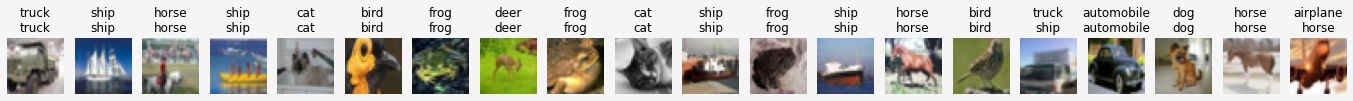

In [21]:
## Shows examples. Top label - true value, lower one - predicted.

N_EXAMPLES = 20  # should be less or equals than BATCH_SIZE

assert N_EXAMPLES <= BATCH_SIZE

xs, labels = next(iter(dataloader_val))
xs = xs[:N_EXAMPLES]
labels = labels[:N_EXAMPLES]

fig, axs = plt.subplots(1, N_EXAMPLES)
fig.set_figwidth(1.2 * N_EXAMPLES)
for ax, x, label in zip(axs, xs, labels):
    x = x.float()
    ax.axis('off')
    ax.imshow(x.permute(1, 2, 0))
    with torch.no_grad():
        ax.set_title(f'{CLASS_TO_LABEL_DICT[label.item()]}\n{CLASS_TO_LABEL_DICT[model(x.unsqueeze(0).to(DEVICE)).argmax().item()]}')

fig.set_facecolor(FIG_BACKGROUND)

## Metrics

### Accuracy

#### Simple accuracy

In [13]:
def get_score_lists(model=model, dataloader=dataloader_val):
    """ Returns tuple of two lists of cpu tensors for multiclass classificaion: 
    with target, and with predicted classes.
    """
    x_val_list = []
    target_val_list = []
    for x_val, target_val in dataloader:
        with torch.no_grad():
            x_val_list.append(model(x_val.float().to(DEVICE)).argmax(dim=1))
        target_val_list.append(target_val)

    return torch.cat(target_val_list), torch.cat(x_val_list).to('cpu')


score_lists = get_score_lists()

In [14]:
# ACCURACY score
accuracy_score(*score_lists)

0.8541

0.8519  MNet-CIFAR10_MNet-1-step133662

0.8541  MNet-CIFAR10_MNet-1-step187091

#### Accuracy - Monte-Carlo DropOut

In [10]:
DEVICE = 'cpu'
model = model.to(DEVICE)

In [ ]:
# MONTE-CARLO DROPOUT - accuracy score. Only for models with DROPOUT layers!

N = 50  # Monte-Carlo iterations


def mc_do(x, model=model, n=100):
    """Monte-Carlo DropOut calculation for batch-tensor `x`."""
    for m in model.modules():
        if isinstance(m, (nn.Dropout, nn.Dropout2d, nn.Dropout3d)):
            m.train()

    res = []
    with torch.no_grad():
        for i in range(n):
            res.append(model(x.float().to(DEVICE)))

    model.eval()
    return torch.stack(res, dim=1).mean(dim=1).argmax(dim=1)


def get_mc_score_lists(model=model, dataloader=dataloader_val, n=100):
    """The same as `get_score_lists` but for Monte_carlo DropOut calculation."""
    x_val_list = []
    target_val_list = []
    for x_val, target_val in tqdm(dataloader):
        x_val_list.append(mc_do(x=x_val, n=n))
        target_val_list.append(target_val)

    return torch.cat(target_val_list), torch.cat(x_val_list).to('cpu')


# Monte-Carlo DropOut ACCURACY score
accuracy_score(*get_mc_score_lists(n=N))

### Multiclass metrics

#### One-vs-Rest precision, recall, f1

In [155]:
# OvR
# PRECISION, RECALL, F1 scores for One-vs-Rest binary subclassification
ROUND = 2  # round result
pd.DataFrame(
    list(zip(
        CLASS_TO_LABEL_DICT.keys(), 
        CLASS_TO_LABEL_DICT.values(), 
        precision_score(*score_lists, average=None).round(ROUND),
        recall_score(*score_lists, average=None).round(ROUND),
        f1_score(*score_lists, average=None).round(ROUND),
    )),
    columns=['class_number', 'class_name', 'precision', 'recall', 'f1']
)

class_number  class_name  precision  recall    f1
0             0    airplane       0.88    0.85  0.87
1             1  automobile       0.94    0.93  0.94
2             2        bird       0.78    0.82  0.80
3             3         cat       0.75    0.70  0.73
4             4        deer       0.84    0.82  0.83
5             5         dog       0.79    0.80  0.79
6             6        frog       0.84    0.90  0.87
7             7       horse       0.90    0.85  0.88
8             8        ship       0.89    0.94  0.92
9             9       truck       0.92    0.92  0.92

#### Confusion matrix

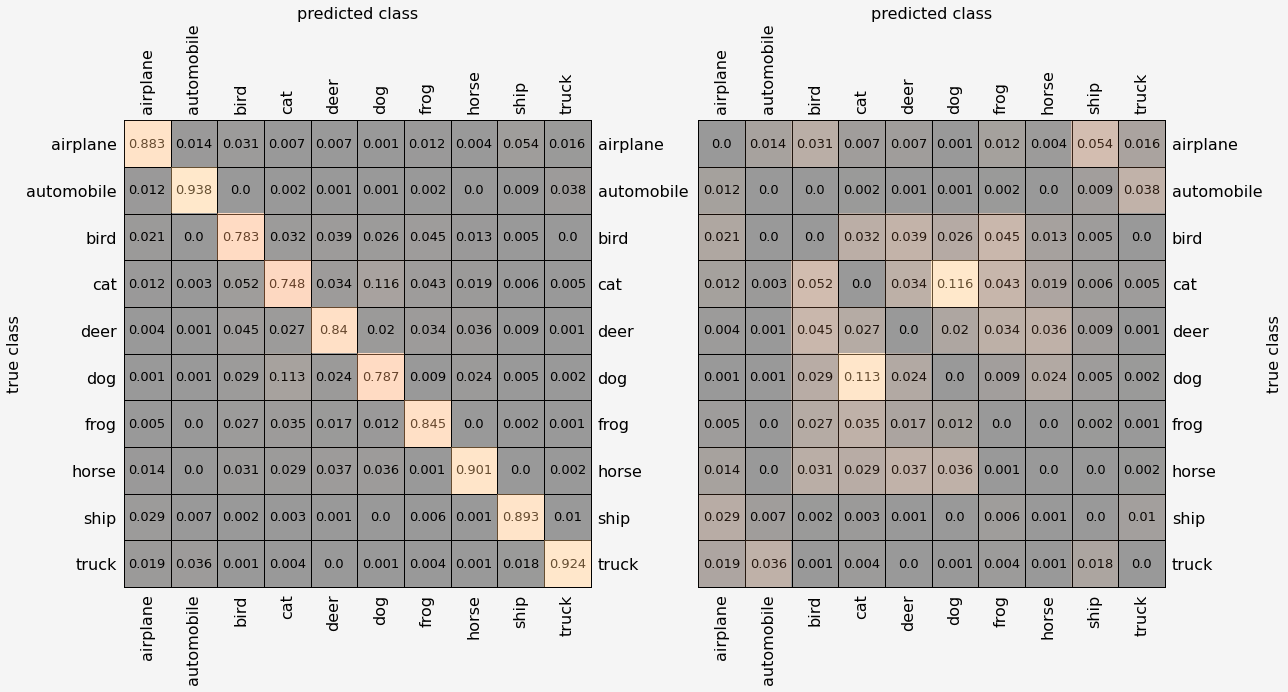

In [146]:
# CONFUSION MATRIX                                              # from sklearn.metrics import plot_confusion_matrix

ROTATE_LABELS = 90  # 0 | 90
NORMALIZE = 'pred'  # None | 'true' | 'pred' | 'all'  # the set to normalize results on
FONTSIZE = 16
ALPHA = 0.4  # opacity of colormap over numbers
CMAP = 'copper'  # colormap name


cfmx = confusion_matrix(*score_lists, normalize=NORMALIZE)
cfmx = np.round(cfmx, 3)

fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18, 10)
ticklabels = list(CLASS_TO_LABEL_DICT.values())


# Plot confusion matrix
axs[0].matshow(cfmx, alpha=ALPHA, cmap=CMAP)
table = axs[0].table(cellText=cfmx, cellLoc='center', bbox=[0 ,0, 1, 1])
table.set_fontsize(FONTSIZE)

axs[0].tick_params(axis='both', which='both', top=False, left=False, bottom=False)
axs[0].tick_params(axis='x', which='both', labeltop=True, labelbottom=True)
axs[0].tick_params(axis='y', which='both', labelleft=True, labelright=True)
axs[0].set_yticks(range(0, len(CLASS_TO_LABEL_DICT)))
axs[0].set_xticks(range(0, len(CLASS_TO_LABEL_DICT)))
axs[0].set_xticklabels(ticklabels, rotation=ROTATE_LABELS, fontsize=FONTSIZE)
axs[0].set_yticklabels(ticklabels, fontsize=FONTSIZE)

axs[0].set_xlabel('predicted class', fontsize=FONTSIZE)
axs[0].set_ylabel('true class', fontsize=FONTSIZE)
axs[0].xaxis.set_label_position('top')


# With main diagonal values set to zero
np.fill_diagonal(cfmx,0)
axs[1].matshow(cfmx, alpha=ALPHA, cmap=CMAP)
table = axs[1].table(cellText=cfmx, cellLoc='center', bbox=[0, 0, 1, 1])
table.set_fontsize(FONTSIZE)

axs[1].tick_params(axis='both', which='both', top=False, left=False, bottom=False)
axs[1].tick_params(axis='x', which='both', labeltop=True, labelbottom=True)
axs[1].tick_params(axis='y', which='both', labelleft=False, labelright=True)
axs[1].set_yticks(range(0, len(CLASS_TO_LABEL_DICT)))
axs[1].set_xticks(range(0, len(CLASS_TO_LABEL_DICT)))
axs[1].set_xticklabels(ticklabels, rotation=ROTATE_LABELS, fontsize=FONTSIZE)
axs[1].set_yticklabels(ticklabels, fontsize=FONTSIZE, )

axs[1].set_xlabel('predicted class', fontsize=FONTSIZE)
axs[1].set_ylabel('true class', fontsize=FONTSIZE)
axs[1].xaxis.set_label_position('top')
axs[1].yaxis.set_label_position('right')

plt.tight_layout(w_pad=1)
fig = plt.gcf()
fig.set_facecolor(FIG_BACKGROUND)

In [73]:
## Confusion matrix to Tensorboard

## as image
tb.add_figure(tag=model._get_name() + "_CM", figure=fig, global_step=1)

## as pr-curve (without ROC-data)
# tb.add_pr_curve(tag=model._get_name(), labels=binary_score_lists[0], predictions=binary_score_lists[1], global_step=step)

### Binary metrics

In [15]:
# Surrogate binary "frog detector" from multiclass

def model_surrogate_binary(x: torch.Tensor, classname: str = 'frog') -> torch.Tensor[bool]:
    """Returns decision (probability) value that class of input is `classname`."""
    with torch.no_grad():
        decision_value = torch.softmax(model(x), dim=1)[:, LABEL_TO_CLASS_DICT['frog']]
    return decision_value 

In [16]:
def get_binary_score_lists(model=model, dataloader=dataloader_val, classname='frog') -> '(torch.Tensor[target_bool], torch.Tensor[probabs])':
    """ Returns tuple of three lists of cpu tensors for binary classificaion: 
    with target, with predicted results and with predicted pobabilities.
    """
    probab_list = []  # list of predicted pobabilities of positivness of class classname
    is_match_list = []  # is predigted result match target
    for n, (x_val, target_val) in enumerate(dataloader):
        probabs = model_surrogate_binary(x_val.float().to(DEVICE), classname=classname)
        probab_list.append(probabs)
        is_match_list.append(target_val == LABEL_TO_CLASS_DICT[classname])

    return torch.cat(is_match_list, dim=0).to('cpu'), torch.cat(probab_list, dim=0).detach().to('cpu'), 


binary_score_lists = get_binary_score_lists()

In [156]:
# Binary metrics

THRESHOLD = 0.5

print('Accuracy -> ', round(accuracy_score(binary_score_lists[0], binary_score_lists[1] > THRESHOLD), 4))
print('Preceision -> ', round(precision_score(binary_score_lists[0], binary_score_lists[1] > THRESHOLD), 4))
print('Recall -> ', round(recall_score(binary_score_lists[0], binary_score_lists[1] > THRESHOLD), 4))
print('F1 -> ', round(f1_score(binary_score_lists[0], binary_score_lists[1] > THRESHOLD), 4))

Accuracy ->  0.977
Preceision ->  0.8873
Recall ->  0.882
F1 ->  0.8847


#### PR and ROC curves

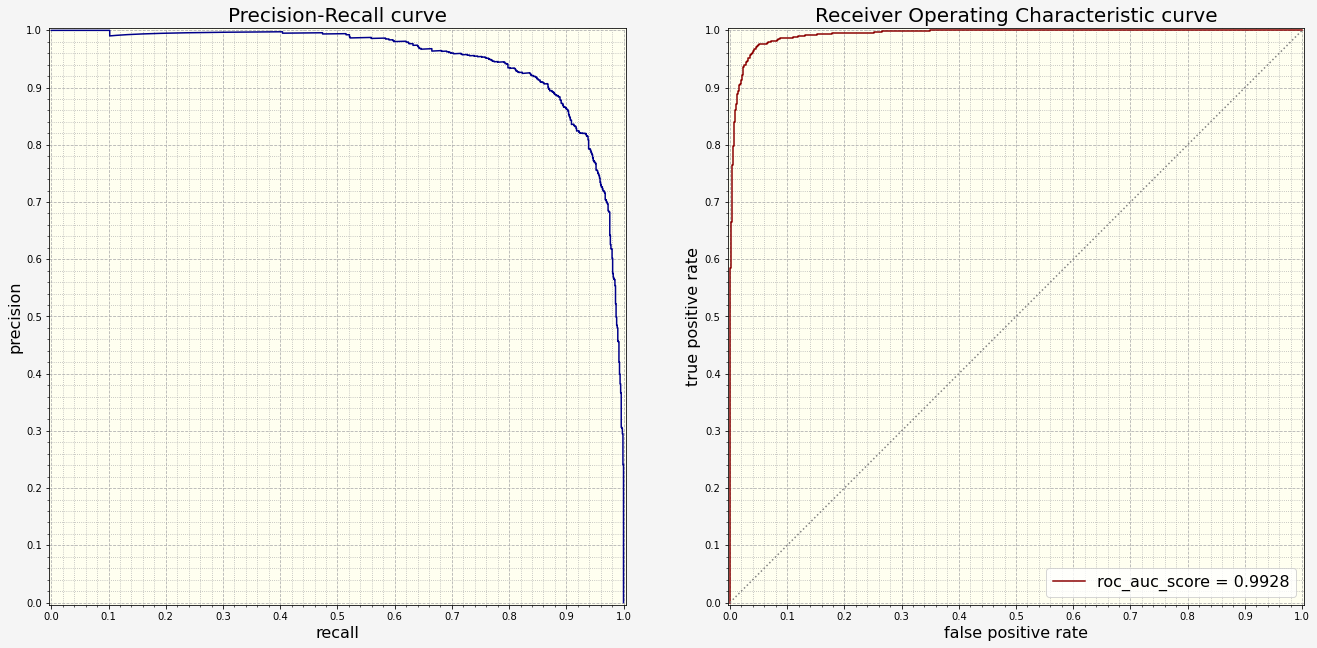

In [143]:
# Plot curves itself

FIGSIZE = (19, 9)  # plot size
FONTSIZE_TITLE = 20
FONTSIZE = 16
EPSILON = 4e-3  # small epsilon for plots range padding


fig, axs = plt.subplots(1, 2)

# PR-curve
prc = precision_recall_curve(binary_score_lists[0], binary_score_lists[1])
prc_plot_values = prc[:2]
prc_plot_values = [1] + list(prc_plot_values[1]) + [0], [0] + list(prc_plot_values[0]) + [1]
axs[0].plot(*prc_plot_values, color='darkblue')
axs[0].set_title('Precision-Recall curve', fontsize=FONTSIZE_TITLE)
axs[0].set_xlabel('recall', fontsize=FONTSIZE)
axs[0].set_ylabel('precision', fontsize=FONTSIZE)

# ROC-curve
roc = roc_curve(binary_score_lists[0], binary_score_lists[1])
roc_plot_values = roc[:2]
roc_plot_values = [0] + list(roc_plot_values[0]) + [1], [0] + list(roc_plot_values[1]) + [1]
axs[1].plot(*roc_plot_values, label=f'roc_auc_score = {round(roc_auc_score(binary_score_lists[0], binary_score_lists[1]), 4)}', color='darkred')
axs[1].plot((0, 1), (0, 1), ':', color='gray')
axs[1].legend(fontsize=FONTSIZE)
axs[1].set_title('Receiver Operating Characteristic curve', fontsize=FONTSIZE_TITLE)
axs[1].set_xlabel('false positive rate', fontsize=FONTSIZE)
axs[1].set_ylabel('true positive rate', fontsize=FONTSIZE)

# Styling
for ax in axs:
    ax.set_aspect(1)
    ax.minorticks_on()
    ax.set_xlim(0 - EPSILON, 1 + EPSILON)
    ax.set_ylim(0 - EPSILON, 1 + EPSILON)
    ax.set_xticks(np.arange(0, 1.000001, 0.1))
    ax.set_yticks(np.arange(0, 1.000001, 0.1))
    ax.grid(which='major', axis='both', linestyle='--')
    ax.grid(which='minor', axis='both', linestyle=':')
    ax.set_facecolor(AXES_BACKGROUND)
fig.set_size_inches(*FIGSIZE)
fig.set_facecolor(FIG_BACKGROUND)
fig.tight_layout()

In [82]:
## PR-curve to Tensorboard

## as image
tb.add_figure(tag=model._get_name() + "_PR+ROC", figure=fig, global_step=step)

## as pr-curve
# tb.add_pr_curve(tag=model._get_name() + "_PR", labels=binary_score_lists[0], predictions=binary_score_lists[1], global_step=step)

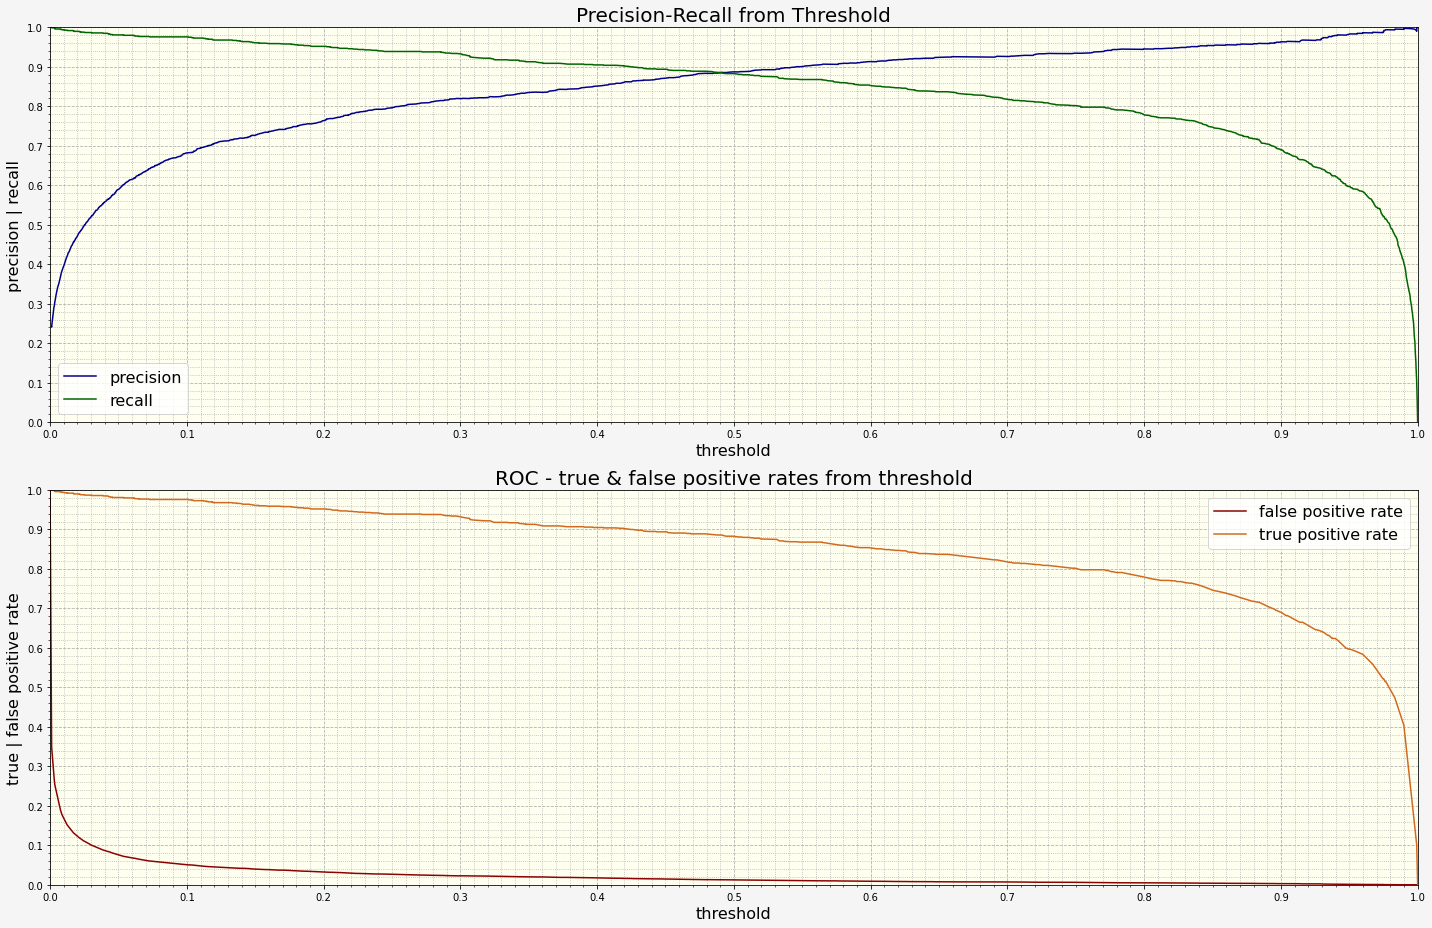

In [159]:
# Plot values dependencies fromthreshold

FIGSIZE = (20, 13)  # plot size
FONTSIZE_TITLE = 20
FONTSIZE = 16
FIG_BACKGROUND = 'whitesmoke'
AXES_BACKGROUND = 'ivory'

fig, axs = plt.subplots(2, 1)

# PR-threshold
prc = precision_recall_curve(binary_score_lists[0], binary_score_lists[1])
axs[0].plot(prc[2], prc[0][:-1], color='darkblue',  label='precision')
axs[0].plot(prc[2], prc[1][:-1], color='darkgreen', label='recall')
axs[0].legend(fontsize=FONTSIZE)
axs[0].set_title('Precision-Recall from Threshold', fontsize=FONTSIZE_TITLE)
axs[0].set_xlabel('threshold', fontsize=FONTSIZE)
axs[0].set_ylabel('precision | recall', fontsize=FONTSIZE)

# ROC-threshold
roc = roc_curve(binary_score_lists[0], binary_score_lists[1])
axs[1].plot(roc[2], roc[0], color='darkred',  label='false positive rate')
axs[1].plot(roc[2], roc[1], color='chocolate', label='true positive rate')
axs[1].legend(fontsize=FONTSIZE)
axs[1].set_title('ROC - true & false positive rates from threshold', fontsize=FONTSIZE_TITLE)
axs[1].set_xlabel('threshold', fontsize=FONTSIZE)
axs[1].set_ylabel('true | false positive rate', fontsize=FONTSIZE)

# Styling
for ax in axs:
    # ax.set_aspect(1)
    ax.minorticks_on()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks(np.arange(0, 1.000001, 0.1))
    ax.set_xticks(np.arange(0, 1, 0.01), minor=True)
    ax.set_yticks(np.arange(0, 1.000001, 0.1))
    ax.grid(which='major', axis='both', linestyle='--')
    ax.grid(which='minor', axis='both', linestyle=':')
    ax.set_facecolor(AXES_BACKGROUND)
    # ax.invert_xaxis()
fig.set_size_inches(*FIGSIZE)
fig.set_facecolor(FIG_BACKGROUND)
plt.tight_layout()